# **Maestría en Inteligencia Artificial Aplicada**

## **Inteligencia Artificial y Aprendizaje Automático**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## **Actividad 9: Modelos sobre datos de Series de Tiempo: Ingenuo / SARIMA / Prophet / LSTM**

### Alumno: Hiram García Austria
### Matrícula: A00378771

In [130]:
## Instalando todas las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Series temporales
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Para trabajar con días hábiles de USA
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Redes Neuronales
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [131]:
ticker_symbol = 'AAPL'   # selecciona las iniciales de la compañía deseada.
data = yf.download(ticker_symbol, period='5y')   # Se indica el período y descargamos.
data.to_csv('historical_data.csv')   # Guardamos los datos

[*********************100%***********************]  1 of 1 completed


In [132]:
# Información de AAPL
df = pd.read_csv('./historical_data.csv', header=0)
df.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-11 00:00:00+00:00,63.54957580566406,65.55000305175781,65.61750030517578,64.56999969482422,64.57499694824219,81821200
3,2019-11-12 00:00:00+00:00,63.49139404296875,65.48999786376953,65.69750213623047,65.2300033569336,65.38749694824219,87388800
4,2019-11-13 00:00:00+00:00,64.09976196289062,66.11750030517578,66.19499969482422,65.26750183105469,65.28250122070312,102734400


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1260 non-null   object
 1   Adj Close  1259 non-null   object
 2   Close      1259 non-null   object
 3   High       1259 non-null   object
 4   Low        1259 non-null   object
 5   Open       1259 non-null   object
 6   Volume     1259 non-null   object
dtypes: object(7)
memory usage: 69.0+ KB


In [134]:
# Resetear el índice
data = data.reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   (Date, )           1258 non-null   datetime64[ns, UTC]
 1   (Adj Close, AAPL)  1258 non-null   float64            
 2   (Close, AAPL)      1258 non-null   float64            
 3   (High, AAPL)       1258 non-null   float64            
 4   (Low, AAPL)        1258 non-null   float64            
 5   (Open, AAPL)       1258 non-null   float64            
 6   (Volume, AAPL)     1258 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 68.9 KB


In [135]:
# Seleccionar las columnas de interés: 'Date' y 'Close'
df = data[['Date', 'Adj Close']]
df.columns = ['ds', 'y']

# Convertir la columna 'ds' a datetime sin zona horaria
df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
print(df.shape)
df.head()

(1258, 2)


C:\Users\hille\AppData\Local\Temp\ipykernel_16228\1155266573.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)


,ds,y
0,2019-11-11,63.549576
1,2019-11-12,63.491394
2,2019-11-13,64.099762
3,2019-11-14,63.656212
4,2019-11-15,64.412422


## **Significado de las variables**

### Adj Close

Es el precio ajustado de una acción al momento del cierre de la jornada laboral. Se le llama ajustado ya que se ajusta por eventos corporativos tales como los dividendos. Al eliminar estas distorsiones se facilita la comparación precisa en el tiempo, permitiendo identificar tendencias y patrones de una forma mas precisa.

### Date

Por otro lado, `Date` representa la fecha de cierre de dicha acción, osea a las 3:00pm hora local de Nueva York (AAPL cotiza en NY).

## **Dividiendo los datos en de Entrenamiento y Prueba**

In [136]:

# Estableciendo la columna 'ds' como índice
df_temp = df.copy()
df_temp.set_index('ds', inplace=True)
print('DF original', df.shape)
print('DF temp', df_temp.shape)

DF original (1258, 2)
DF temp (1258, 1)


In [137]:
# Observamos que aquí todavía no se tiene información del argumento "freq"
df_temp.index

DatetimeIndex(['2019-11-11', '2019-11-12', '2019-11-13', '2019-11-14',
               '2019-11-15', '2019-11-18', '2019-11-19', '2019-11-20',
               '2019-11-21', '2019-11-22',
               ...
               '2024-10-28', '2024-10-29', '2024-10-30', '2024-10-31',
               '2024-11-01', '2024-11-04', '2024-11-05', '2024-11-06',
               '2024-11-07', '2024-11-08'],
              dtype='datetime64[ns]', name='ds', length=1258, freq=None)

In [138]:
# Ajustando la frecuencia de los índices
# para ayudar a que el modelo tenga información del período en que se encuentran los datos
# B de business day (días hábiles)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

df_temp = df_temp.asfreq('B')
df_temp.index

DatetimeIndex(['2019-11-11', '2019-11-12', '2019-11-13', '2019-11-14',
               '2019-11-15', '2019-11-18', '2019-11-19', '2019-11-20',
               '2019-11-21', '2019-11-22',
               ...
               '2024-10-28', '2024-10-29', '2024-10-30', '2024-10-31',
               '2024-11-01', '2024-11-04', '2024-11-05', '2024-11-06',
               '2024-11-07', '2024-11-08'],
              dtype='datetime64[ns]', name='ds', length=1305, freq='B')

In [139]:
# Revisamos si hay valores faltantes
df_temp.isnull().sum()


y    47
dtype: int64

In [140]:
# Rellenar los valores faltantes con el valor no nulo más cercano anterior en la columna
df_temp.fillna(method='ffill', inplace=True)
df_temp.isnull().sum()

C:\Users\hille\AppData\Local\Temp\ipykernel_16228\1492250501.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_temp.fillna(method='ffill', inplace=True)


y    0
dtype: int64

In [141]:
# Dividir los datos en entrenamiento y prueba
train = df_temp.iloc[0:-20, :]

# Las últimas 20 filas para el conjunto de prueba
test = df_temp.iloc[-20:, :]

print('Entrenamiento:', train.shape)

Entrenamiento: (1285, 1)


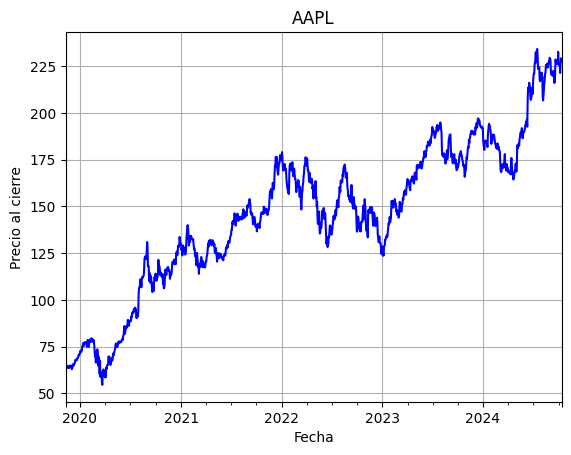

In [142]:
# Gráfico con la periodicidad diaria durante 5 años:
train['y'].plot(title='AAPL', style='-b')
plt.xlabel('Fecha')
plt.ylabel('Precio al cierre')
plt.grid()
plt.show()

## **Modelo ingenuo: SIN ESCALAR**

In [143]:
# Función para obtener el RMSE
def naive_forecast(train, test):
    # Definimos "history" donde de manera incremental se irán agregando registros mensuales.
    history = [x for x in train['y'].values]
    # Lista que contendrá las predicciones del modelo ingenuo.
    predictions = list()

    for i in range(len(test['y'])):
        # Obtenemos las predicciones:
        yhat = history[-1]  # La primera vez, tomamos el último dato del Train, en las siguientes, se van agregando los datos de Test.
        predictions.append(yhat)

        # Observaciones-registros reales:
        obs = test.iloc[i]['y']  # Ahora vamos tomando los datos de Test.
        history.append(obs)  # Vamos agregando a "history" (que ya tiene todo los de Train) en cada iteración, un dato más de los de Test.
        print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

    # Calculamos la raíz del error cuadrático medio (RMSE):
    rmse_naive = np.sqrt(mean_squared_error(test['y'].values, predictions))
    print('\nError-Modelo-Naive: RMSE: %.3f' % rmse_naive)

    return predictions, rmse_naive

# Función para gráficar la serie de tiempo con o sin zoom
def plot_series(titulo, train, test, predictions, zoom=False):
    fig, ax = plt.subplots(figsize=(14, 4))
    ax = plt.plot(train['y'], '-k')  # Datos de entrenamiento de 1949 a 1959 (los históricos).
    ax = plt.plot(test['y'], '+b')    # Datos de prueba reales del año 1960 (los del útimo año a predecir).
    ax = plt.plot(test.index, predictions, 'xr')  # Predicciones del modelo ingenuo para el último año 1960.
    plt.grid()
    plt.title('AAPL - Modelo Ingenuo: ' + titulo)
    plt.xlabel('Fecha')
    plt.ylabel('Precio al cierre')

    # Mostrar los últimos 50 días (30 + 20) para una mejor visualización
    if zoom:
        plt.xlim(train.index[-30], test.index.max())
        plt.ylim(test['y'].min(), test['y'].max())

    plt.show()

>Esperado-real = 231, Predicción = 227.300
>Esperado-real = 233, Predicción = 231.046
>Esperado-real = 231, Predicción = 233.593
>Esperado-real = 231, Predicción = 231.525
>Esperado-real = 234, Predicción = 231.895
>Esperado-real = 236, Predicción = 234.742
>Esperado-real = 235, Predicción = 236.220
>Esperado-real = 230, Predicción = 235.601
>Esperado-real = 230, Predicción = 230.506
>Esperado-real = 231, Predicción = 230.317
>Esperado-real = 233, Predicción = 231.156
>Esperado-real = 233, Predicción = 233.143
>Esperado-real = 229, Predicción = 233.413
>Esperado-real = 225, Predicción = 229.847
>Esperado-real = 222, Predicción = 225.662
>Esperado-real = 221, Predicción = 222.665
>Esperado-real = 223, Predicción = 221.766
>Esperado-real = 222, Predicción = 223.204
>Esperado-real = 227, Predicción = 222.475
>Esperado-real = 226, Predicción = 227.230

Error-Modelo-Naive: RMSE: 2.565


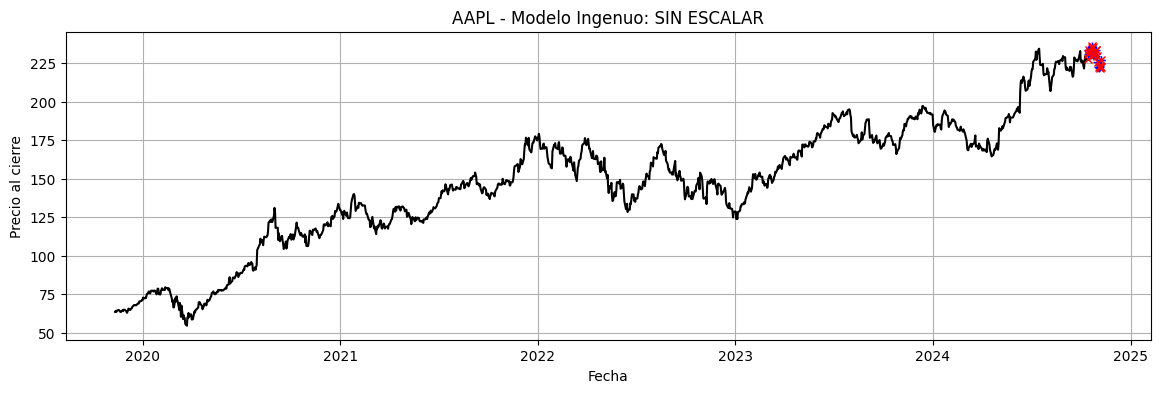

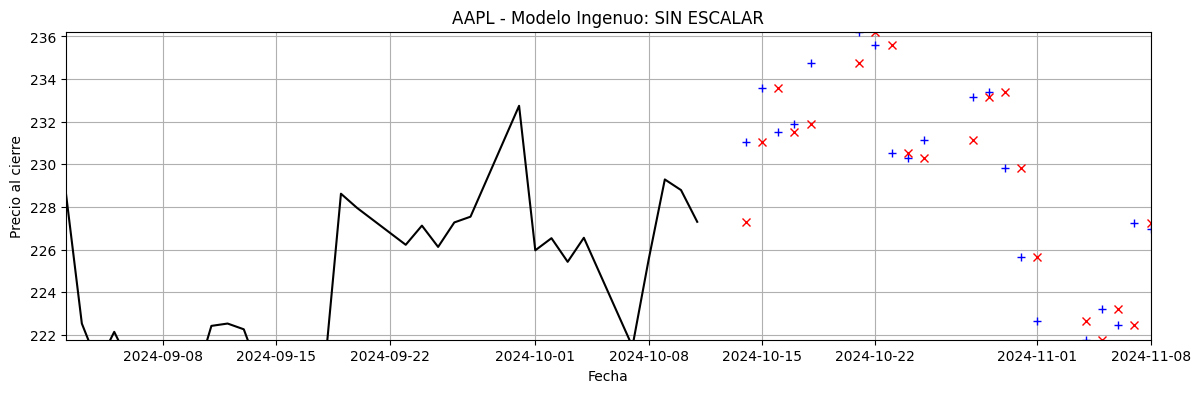

In [144]:
predictions, rmse_naive = naive_forecast(train, test)
plot_series('SIN ESCALAR', train, test, predictions)
plot_series('SIN ESCALAR', train, test, predictions, zoom=True)

## **Modelo ingenuo: CON ESCALADO**

>Esperado-real =   0, Predicción = 0.961
>Esperado-real =   0, Predicción = 0.982
>Esperado-real =   0, Predicción = 0.996
>Esperado-real =   0, Predicción = 0.985
>Esperado-real =   1, Predicción = 0.987
>Esperado-real =   1, Predicción = 1.003
>Esperado-real =   1, Predicción = 1.011
>Esperado-real =   0, Predicción = 1.007
>Esperado-real =   0, Predicción = 0.979
>Esperado-real =   0, Predicción = 0.978
>Esperado-real =   0, Predicción = 0.983
>Esperado-real =   0, Predicción = 0.994
>Esperado-real =   0, Predicción = 0.995
>Esperado-real =   0, Predicción = 0.975
>Esperado-real =   0, Predicción = 0.952
>Esperado-real =   0, Predicción = 0.935
>Esperado-real =   0, Predicción = 0.930
>Esperado-real =   0, Predicción = 0.938
>Esperado-real =   0, Predicción = 0.934
>Esperado-real =   0, Predicción = 0.961

Error-Modelo-Naive: RMSE: 0.014


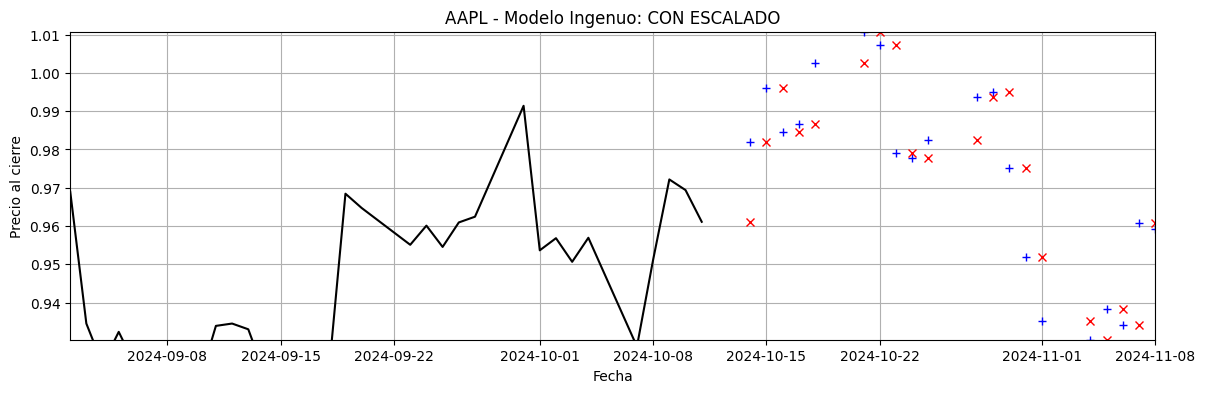

In [145]:
# Escalando los datos de 0 a 1 con MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Transformar a dataframes
train_scaled = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)

predictions, rmse_naive = naive_forecast(train_scaled, test_scaled)
plot_series('CON ESCALADO', train_scaled, test_scaled, predictions, zoom=True)

## **Modelo ingenuo: Análisis**

El modelo ingenuo es un buen punto de partida para comparar con otros modelos.

El RMSE es una medida de error que nos permite comparar modelos. En este caso, el modelo SIN ESCALAR tiene un RMSE de 2.5, lo que significa que en promedio, las predicciones están a 2.5 unidades de distancia del valor real. Mientras que el modelo CON ESCALADO tiene un RMSE de 0.01, por lo que es mucho más preciso que el modelo SIN ESCALAR.

El escalado de los datos es importante para que el modelo pueda aprender de manera más eficiente y precisa. En este caso, el modelo CON ESCALADO es mucho mejor que el modelo SIN ESCALAR.

## **Modelo ARIMA: SIN ESCALAR**

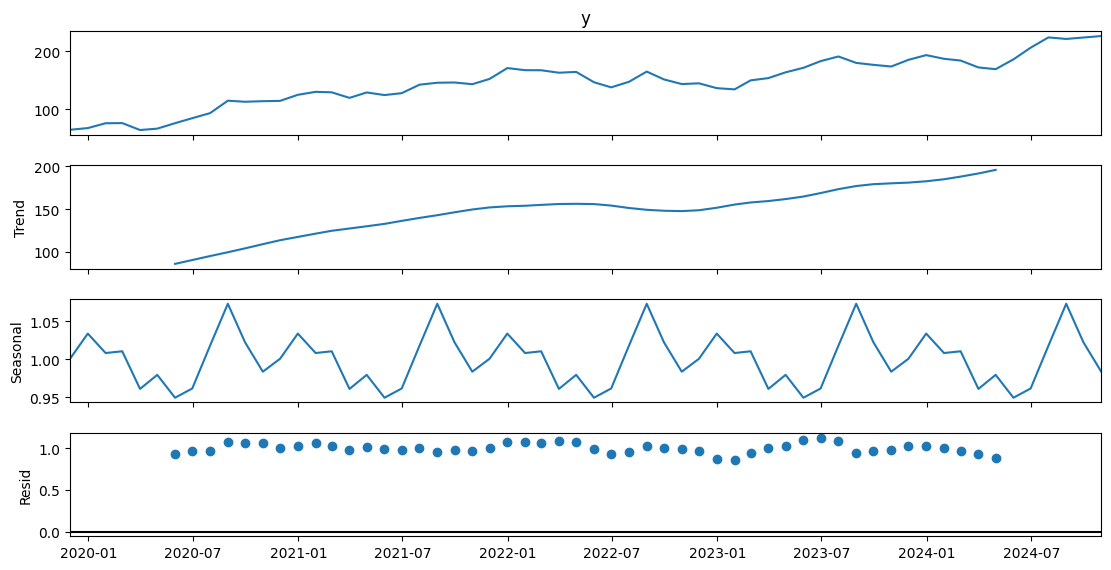

In [146]:
# Gráficos de descomposición estacional:
decomposition = seasonal_decompose(train['y'].resample('ME').mean(), model='multiplicative')  # <<<---- Observa que el modelo es multiplicativo
fig = decomposition.plot()
fig.set_size_inches(12,6)
plt.show()

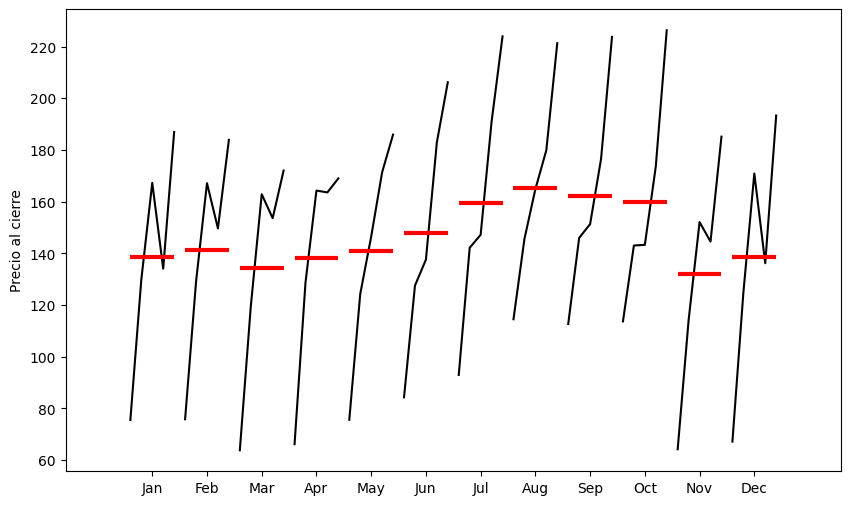

In [147]:
# Gráfica para detección de estacionalidad mensual:
fig = month_plot(train['y'].resample('ME').mean(), ylabel='Precio al cierre')
fig.set_size_inches(10,6)
plt.show()

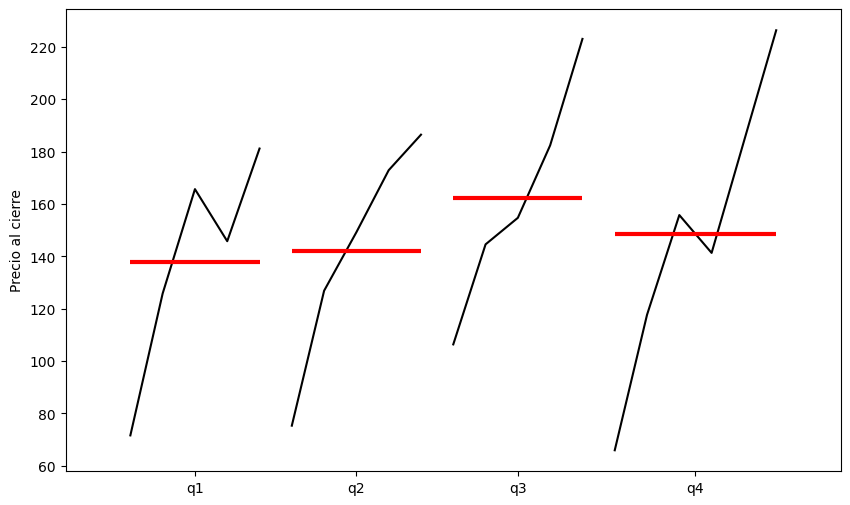

In [148]:
# Si queremos graficar y detectar estacionalidad trimestral:
fig = quarter_plot(train['y'].resample('QE').mean(), ylabel='Precio al cierre')
fig.set_size_inches(10,6)
plt.show()

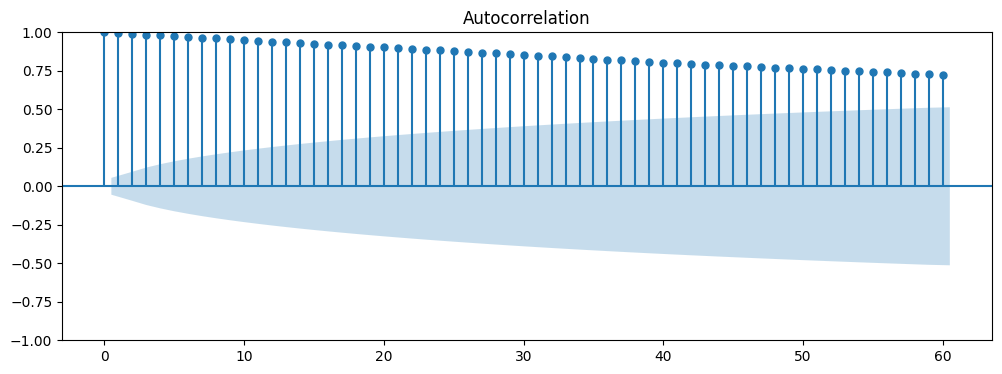

In [149]:
# Gráfico de Auto-correlación (ACF: Auto-Correlation-Function)
fig,ax = plt.subplots(figsize = (12,4))
plot_acf(train['y'], lags=60, ax=ax)   # Eliges el número de unidades (meses) desfasadas. El número de "lags" es el número
plt.show()                          # que define la partición en el eje horizontal. El área no sombreada nos habla de
                                    # la cantidad de períodos de tiempo hacia atrás cuya información proporcionada es
                                    # significativa para la predicción futura.
                                    # También nos ayuda a detectar periodicidades, como en este caso que se observa a 13 meses, aprox.

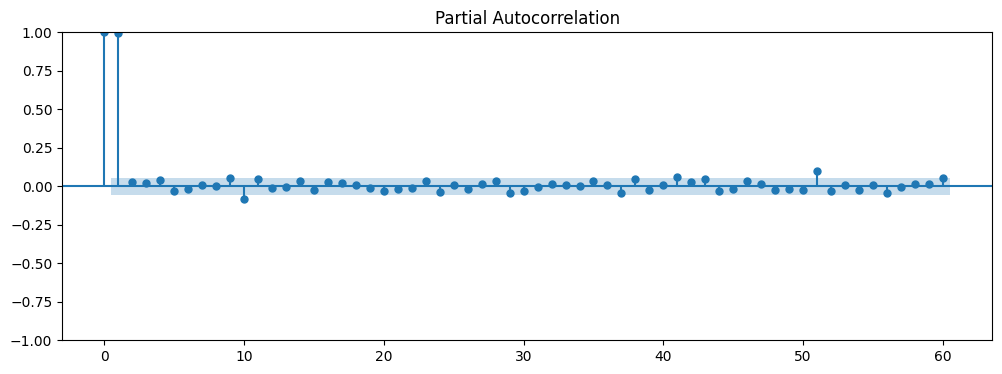

In [150]:
# Gráfico de Auto-correlación Parcial (PACF):
fig, ax = plt.subplots(figsize = (12,4))
plot_pacf(train['y'], lags = 60, ax = ax, method="ols")   # ols: regression of time series on lags of it an on constant. predeterminado method="ywm"
plt.show()

In [151]:
# Lo primero es para quitar la estacionalidad y transformar un problema
# de tipo no-estacionario (SARIMA) en uno estacionario (ARIMA):

# Diferencia de datos consecutivos en el tiempo y podemos ahora usar ARIMA:
def difference(dataset, interval=1):
  diff = list()

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return np.array(diff)

# Invierte las diferencias anteriores, es decir, nos regresa la estacionalidad:
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]

def arima_forecast(train, test):
    # Definimos la lista de registros de pasajeros en el tiempo
    history = [x for x in train.loc[:, 'y'].values]  # Lista con los datos del train
    predictions_arima = list()  # Para incluir las predicciones que vaya generando el modelo

    for i in range(len(test['y'])):
        months_in_year = 12
        diff = difference(history, months_in_year)  # Lista de los datos de diferencias para transformar SARIMA en ARIMA

        # Generamos el modelo
        model = ARIMA(diff, order=(3, 0, 13))  # Si aplicamos diff, entonces d=0 es aplicable
        model_fit = model.fit(method_kwargs={'maxiter': 300})  # Aumentar las iteraciones para evitar el WarningConvergence

        yhat = model_fit.forecast()[0]  # Predicciones (yhat) de cada registro, es un solo número flotante
        yhat = inverse_difference(history, yhat, months_in_year)  # El nuevo "yhat" es cada un nuevo valor (float) de predicción
        predictions_arima.append(yhat)  # Lista que se va incrementando al ir agregando cada predicción nueva

        # Observaciones-reales
        obs = test.iloc[i]['y']  # Cada dato es un flotante
        history.append(obs)  # Se va incrementado a partir del Train con los registros-observaciones reales

        print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

    # Error RMSE
    rmse_arima = np.sqrt(mean_squared_error(test['y'].values, predictions_arima))
    print('\nError-Modelo-ARIMA: RMSE: %.3f' % rmse_arima)

    return predictions_arima, rmse_arima

def plot_arima_forecast(title, train, test, predictions, zoom=False):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax = plt.plot(train['y'], '-k', label='Entrenamiento')  # Datos de entrenamiento
    ax = plt.plot(test['y'], '-b', label='Prueba')  # Datos de prueba reales
    ax = plt.plot(test['y'], '+c', label='Prueba (puntos)')  # Datos de prueba reales (puntos)
    ax = plt.plot(test.index, predictions, 'xr', label='Predicciones')  # Predicciones del modelo
    plt.grid()
    plt.title('AAPL - Modelo ARIMA: ' + title)
    plt.xlabel('Fecha')
    plt.ylabel('Precio al cierre')
    plt.legend()

    if zoom:
        plt.xlim(train.index[-30], test.index.max())
        plt.ylim(test['y'].min(), test['y'].max())

    plt.show()

In [152]:
predictions_arima, rmse_arima = arima_forecast(train, test)

>Esperado-real = 231, Predicción = 228.162
>Esperado-real = 233, Predicción = 231.438
>Esperado-real = 231, Predicción = 233.175
>Esperado-real = 231, Predicción = 231.020
>Esperado-real = 234, Predicción = 232.460
>Esperado-real = 236, Predicción = 234.423
>Esperado-real = 235, Predicción = 236.321
>Esperado-real = 230, Predicción = 235.700
>Esperado-real = 230, Predicción = 230.493
>Esperado-real = 231, Predicción = 230.387
>Esperado-real = 233, Predicción = 231.081
>Esperado-real = 233, Predicción = 233.026
>Esperado-real = 229, Predicción = 234.320


c:\Users\hille\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Esperado-real = 225, Predicción = 230.287


c:\Users\hille\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Esperado-real = 222, Predicción = 225.300


c:\Users\hille\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Esperado-real = 221, Predicción = 222.234
>Esperado-real = 223, Predicción = 222.545


c:\Users\hille\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Esperado-real = 222, Predicción = 222.954
>Esperado-real = 227, Predicción = 222.831
>Esperado-real = 226, Predicción = 227.379

Error-Modelo-ARIMA: RMSE: 2.512


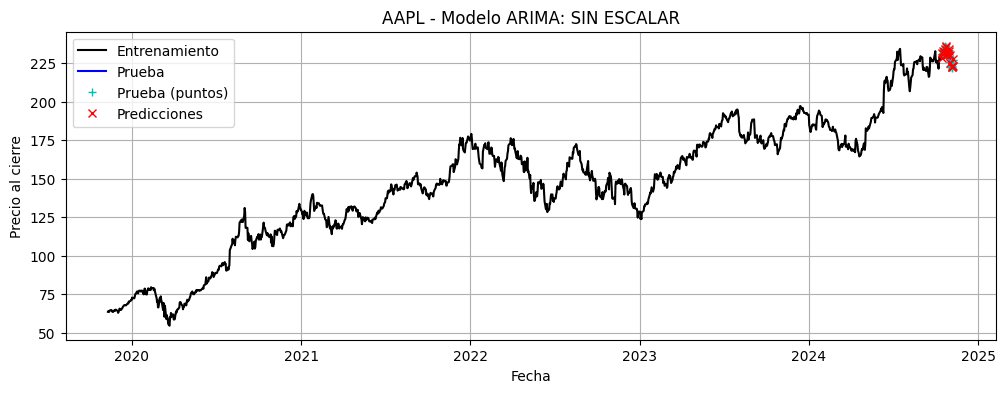

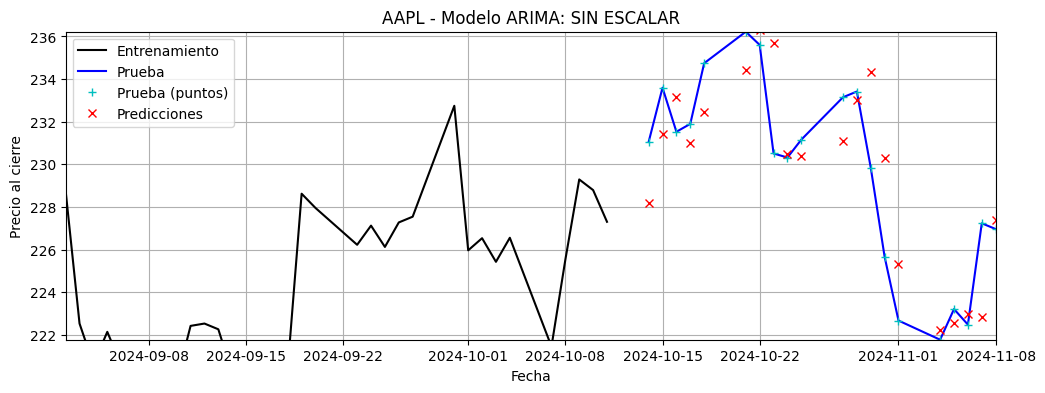

In [153]:
plot_arima_forecast('SIN ESCALAR', train, test, predictions_arima)
plot_arima_forecast('SIN ESCALAR', train, test, predictions_arima, zoom=True)

## **Modelo ARIMA: CON ESCALADO**

In [154]:
predictions_arima, rmse_arima = arima_forecast(train_scaled, test_scaled)

>Esperado-real =   0, Predicción = 0.964


c:\Users\hille\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Esperado-real =   0, Predicción = 0.984
>Esperado-real =   0, Predicción = 0.994
>Esperado-real =   0, Predicción = 0.983
>Esperado-real =   1, Predicción = 0.989
>Esperado-real =   1, Predicción = 1.000
>Esperado-real =   1, Predicción = 1.013
>Esperado-real =   0, Predicción = 1.009


c:\Users\hille\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


>Esperado-real =   0, Predicción = 0.979
>Esperado-real =   0, Predicción = 0.977
>Esperado-real =   0, Predicción = 0.983
>Esperado-real =   0, Predicción = 0.995
>Esperado-real =   0, Predicción = 0.998
>Esperado-real =   0, Predicción = 0.979
>Esperado-real =   0, Predicción = 0.952
>Esperado-real =   0, Predicción = 0.935
>Esperado-real =   0, Predicción = 0.934
>Esperado-real =   0, Predicción = 0.937
>Esperado-real =   0, Predicción = 0.938
>Esperado-real =   0, Predicción = 0.962

Error-Modelo-ARIMA: RMSE: 0.014


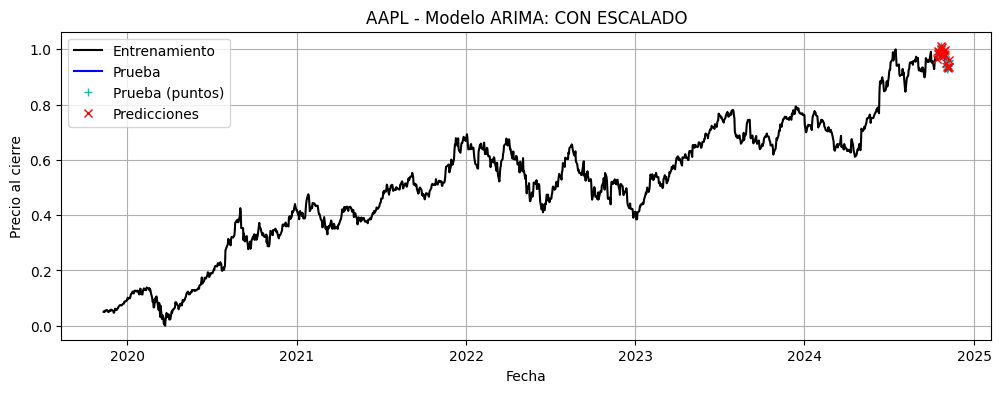

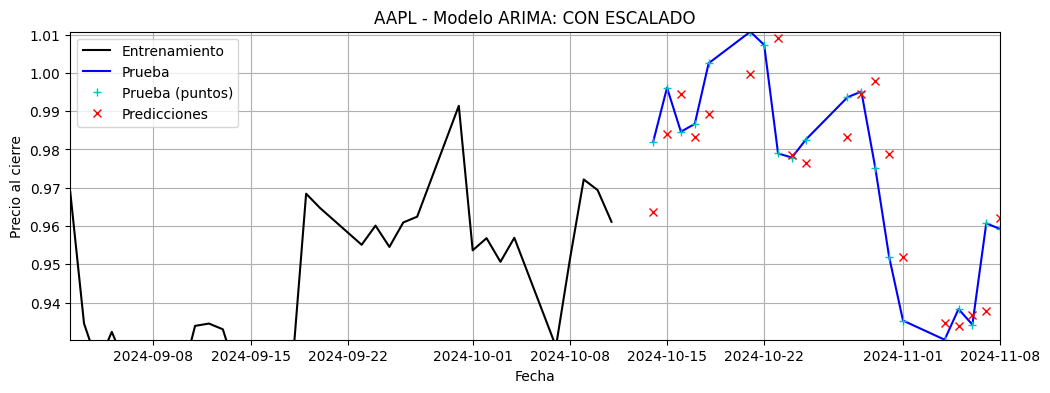

In [155]:
plot_arima_forecast('CON ESCALADO', train_scaled, test_scaled, predictions_arima)
plot_arima_forecast('CON ESCALADO', train_scaled, test_scaled, predictions_arima, zoom=True)

## **Modelo ARIMA: Análisis**

Observando el Gráfico de descomposición estacional podemos ver que la serie temporal tiene una tendencia y una estacionalidad clara. Que es notoria sobretodo en el gráfico de estacionalidad trimestral, donde vemos que el 1er y 4to trimestre del año son los que tienen mayor variabilidad en los precios de cierre.

Para los RSME obtenidos, vemos que el modelo **ARIMA (2.512)** tiene un error ligeramente menor que el **modelo ingenuo (2.565)**, tanto en los datos sin escalar como en los datos escalados. Por lo que, en este caso, ambos modelos tienen un desempeño similar.

Cuando usamos el escalado de los datos, obtenemos una mejora notable en el **RSME (0.01)**, similar al modelo ingenuo, lo que nos confirma que el modelo ARIMA se beneficia de tener los datos en una escala común.

## **Modelo Prophet: SIN ESCALAR**

In [214]:
# Prophet requiere que la entrada sean dos columnas, llamadas "ds" y "y".
train_prophet = df.iloc[0:-20,:]
test_prophet = df.iloc[-20:,:]

# Checando si hay valores faltantes
train_prophet.isnull().sum()

ds    0
y     0
dtype: int64

In [215]:
modelo = Prophet(
    seasonality_mode='multiplicative',  # Modelo multiplicativo
    # yearly_seasonality=True,  # Estacionalidad anual
    interval_width=0.95,  # Intervalo de confianza
    changepoint_prior_scale=10,  # Escala de cambio de puntos
    seasonality_prior_scale=18,  # Escala de estacionalidad, mayor el valor, mayor flexibilidad en la estacionalidad.
)

# Ajustar el modelo
modelo.fit(train_prophet)

16:47:53 - cmdstanpy - INFO - Chain [1] start processing
16:47:53 - cmdstanpy - INFO - Chain [1] done processing


In [216]:
def prophet_forecast(modelo, test):
    # Realizar las predicciones
    forecast = modelo.predict(test)

    # Extraer las predicciones
    pred_FP = forecast['yhat'].values

    # Calcular el error RMSE
    rmse_prophet = np.sqrt(mean_squared_error(test['y'], pred_FP))
    print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse_prophet)

    return rmse_prophet


def plot_prophet_forecast(title, model, test, zoom=False):
    forecast = model.predict(test)

    fig, ax = plt.subplots(figsize=(12, 5))
    model.plot(forecast, ax=ax)               # Las predicciones se muestran con la línea continua, junto con su región de variabilidad de la predicción.
    ax = plt.plot(test['ds'], test['y'], '*r')   # Agregamos los datos de prueba (Test) con puntos rojos, para observar la diferencia.
    ax = plt.plot(test['ds'], forecast['yhat'], '+c')    # Valores reales.
    plt.grid()
    plt.title('AAPL - Modelo Facebook Prophet: ' + title)
    plt.xlabel('Fecha')
    plt.ylabel('Precio al cierre')

    if zoom:
        plt.xlim(test['ds'].min() - pd.Timedelta(days=30), test['ds'].max())
        plt.ylim(test['y'].min(), test['y'].max())

    plt.show()

In [217]:
# Calculamos el error RMSE:
rmse_prophet = prophet_forecast(modelo, test_prophet)


Error-Modelo-FacebookProphet: RMSE: 8.194


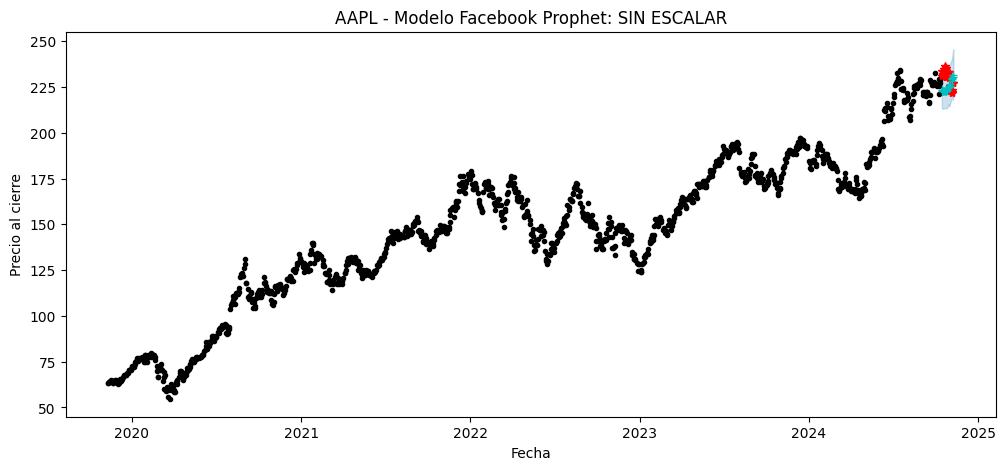

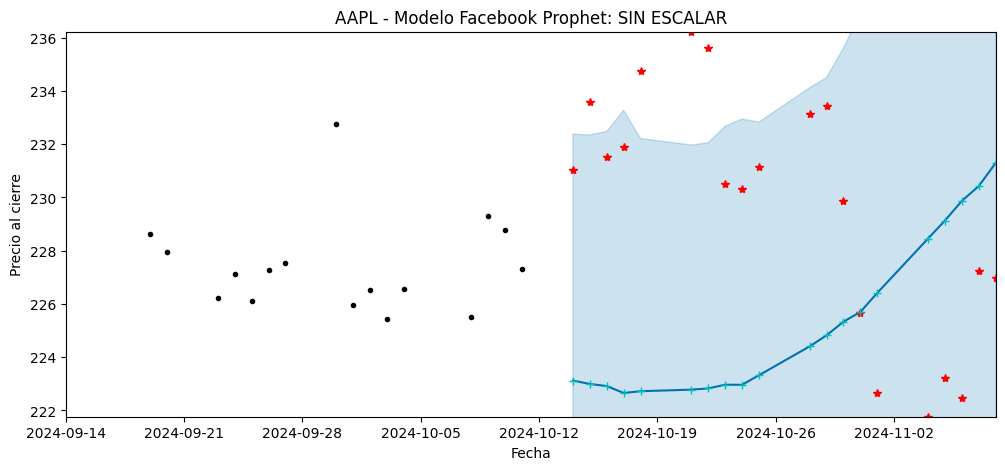

In [218]:
# Graficando las predicciones:
plot_prophet_forecast('SIN ESCALAR', modelo, test_prophet)
plot_prophet_forecast('SIN ESCALAR', modelo, test_prophet, zoom=True)

## **Modelo Prophet: CON ESCALADO**

In [219]:
# Escalando los datos de 0 a 1 con MinMaxScaler
scaler_prophet = MinMaxScaler(feature_range=(0, 1))
train_prophet_scaled_values = scaler_prophet.fit_transform(train_prophet[['y']])
test_prophet_scaled_values = scaler_prophet.transform(test_prophet[['y']])

# Recombinar las fechas con los datos escalados y asegurarse que los indices sean los mismos
train_prophet_scaled = pd.DataFrame(train_prophet_scaled_values, columns=['y'], index=train_prophet.index)
train_prophet_scaled['ds'] = train_prophet['ds']

test_prophet_scaled = pd.DataFrame(test_prophet_scaled_values, columns=['y'], index=test_prophet.index)
test_prophet_scaled['ds'] = test_prophet['ds']

In [220]:
modelo_escalado = Prophet(
    seasonality_mode='multiplicative',  # Modelo multiplicativo
    # yearly_seasonality=True,  # Estacionalidad anual
    interval_width=0.95,  # Intervalo de confianza
    changepoint_prior_scale=10,  # Escala de cambio de puntos
    seasonality_prior_scale=18,  # Escala de estacionalidad, mayor el valor, mayor flexibilidad en la estacionalidad.
)

# Ajustar el modelo
modelo_escalado.fit(train_prophet_scaled)

# Calculando el error RMSE:
rmse_prophet_escalado = prophet_forecast(modelo_escalado, test_prophet_scaled)

16:48:14 - cmdstanpy - INFO - Chain [1] start processing
16:48:14 - cmdstanpy - INFO - Chain [1] done processing



Error-Modelo-FacebookProphet: RMSE: 0.045


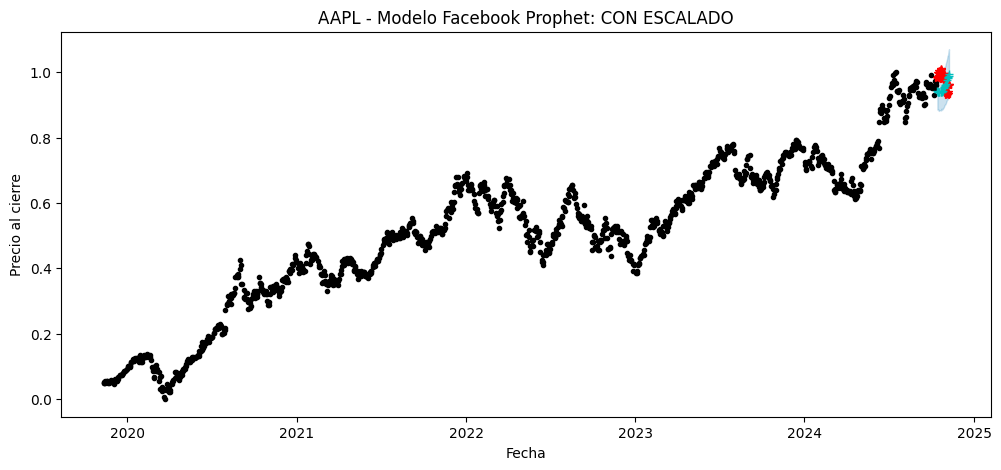

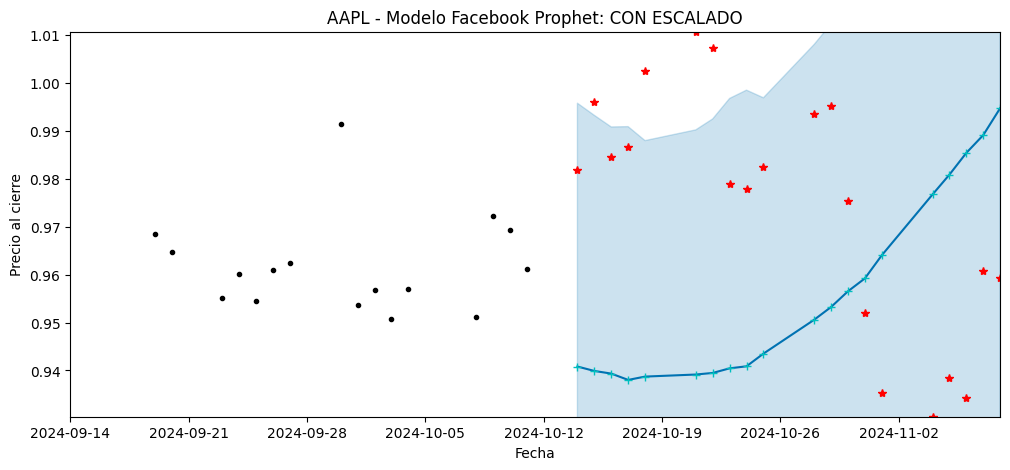

In [221]:
# Graficando las predicciones:
plot_prophet_forecast('CON ESCALADO', modelo_escalado, test_prophet_scaled)
plot_prophet_forecast('CON ESCALADO', modelo_escalado, test_prophet_scaled, zoom=True)

## **Modelo Prophet: Análisis**

Comparando los errores RMSE de los modelos Prophet con y sin escalar, se observa que el modelo sin escalar obtuvo un **RMSE: 8.194**, mientras que el modelo con escalado obtuvo un **RMSE: 0.045**, muy por arriba de los resultados que veníamos obteniendo con los modelo ARIMA e Ingenuo.

También podemos notar que las predicciones que hace este modelo son un tanto conservadoras ya que se sitúan justo por en medio de los valores.

## **Modelo LSTM: SIN ESCALAR**

In [222]:
def preparando_datos(myData, myDate):

  # ++++++++ TRAIN +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Los datos de entrenamiento son previos a la fecha "Date" que indiques y
  # tomarán hisotriales en este caso de 12 períodos previos.
  Train_Data = myData['y'][myData['ds'] < myDate].to_numpy()

  periodo = 12   # 12 meses al año

  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []

  for i in range(0, len(Train_Data), periodo):    # observa que va formando el Train set con historiales de 12 períodos consecutivos.
    try:
      Data_Train.append(Train_Data[i : i + periodo])
    except:
      pass


  # En ocasiones hay datos perdidos, en cuyo caso la última serie
  # de datos la eliminamos:
  if len(Data_Train[-1]) < periodo:
    Data_Train.pop(-1)


  # Hay que darle la forma (dimensionalidad) que requieren los modelos
  # de aprendizaje profundo, en particular la librería de TensorFlow:
  #     (batch_size, sequence_length, input_dimension).

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, periodo, 1))

  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, periodo, 1))


  # +++++++++++ TEST +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Los datos de prueba (Test) son posteriores a la fecha "Date" y que es el
  # último ciclo que deseas predecir:
  Test_Data = myData['y'][myData['ds'] >= myDate].to_numpy()

  # inicialización de listas:
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []

  for i in range(0, len(Test_Data), periodo):
    try:
      Data_Test.append(Test_Data[i : i + periodo])
    except:
      pass


  if len(Data_Test[-1]) < periodo:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, periodo, 1))

  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, periodo, 1))


  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y


In [233]:
# Continuemos con el DataFrame como en Prophet:

threshold_Date = '2023-11-08'   # A partir de esta fecha se empieza a generar el Test.

# Recuerda que la columna de fechas del DataFrame df, debe ser de tipo DateTime.
# Se generan paquetes de 12 meses. Los *_Y son los años desfasados hacia adelante
# de los *_X:

Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df, threshold_Date)

In [234]:
# Podemos definir la manera en que el tamaño de paso (learning-rate) varíe
# en cada época. Es usual definir también algunas funciones, exponenciales,
# por ejemplo. Por el momento definamos valores constantes por intervalos:

def scheduler(epoch):

  if epoch <= 100:
    lrate = 0.05
  elif epoch <= 180:
    lrate = 0.0005
  elif epoch <=190:
    lrate = 0.00005
  else:
    lrate = (10 ** -5)

  return lrate

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [331]:
def myModel():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(20, input_shape=(12, 1),
        activation=tf.nn.leaky_relu, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.LSTM(20, activation=tf.nn.leaky_relu),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(200, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.Dense(120, activation=tf.nn.leaky_relu),
        tf.keras.layers.Dense(12, activation=tf.nn.leaky_relu)
    ])
    return model

def plot_LSTM_forecast(title, Train_X, Train_Y, Test_X, Test_Y):
    my_LSTM_model2 = myModel()
    my_LSTM_model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    H = my_LSTM_model2.fit(Train_X, Train_Y, epochs=200, validation_data=(Test_X, Test_Y), callbacks=[callback])
    N = 50  # Para omitir los N primeros valores en la gráfica, que en ocasiones son
            # demasiado grandes los errores y no dejan apreciar las curvas de aprendizaje.
    epochs = range(N+1, len(H.history["loss"]) + 1)

    fig, ax2 = plt.subplots(figsize=(12, 5))
    ax2.plot(epochs, H.history["root_mean_squared_error"][N:], label = "Training Root Mean Squared Error")
    ax2.plot(epochs, H.history["val_root_mean_squared_error"][N:], label = "Validation Root Mean Squared Error")
    ax2.set(xlabel = "Epochs", ylabel = "Loss-RMSE")
    ax2.legend()
    plt.grid()
    plt.title("AAPL - Modelo LSTM: " + title)
    plt.show()

    return my_LSTM_model2

def LSTM_forecast(model, Test_X, Test_Y):
    predictions_LSTM = model.predict(Test_X)
    rmse_LSTM = np.sqrt(mean_squared_error(Test_Y[:, -1, 0], predictions_LSTM[:, -1, 0]))
    print('\nError-Modelo-LSTM: RMSE: %.3f' % rmse_LSTM)

    return predictions_LSTM, rmse_LSTM

def plot_LSTM_forecast2(title, train, test, predictions, zoom=False):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(train['ds'], train['y'], '-k', label='Entrenamiento')
    ax.plot(test['ds'], test['y'], '-b', label='Prueba')
    ax.plot(test['ds'], test['y'], '+c', label='Prueba (puntos)')
    ax.plot(test['ds'], predictions[:, -1, 0], 'xr', label='Predicciones')
    plt.grid()
    plt.legend()
    plt.title('AAPL - Modelo LSTM: ' + title)
    plt.xlabel('Fecha')
    plt.ylabel('Precio al cierre')

    if zoom:
        plt.xlim(test['ds'].min() - pd.Timedelta(days=60), test['ds'].max() + pd.Timedelta(days=30))
        plt.ylim(test['y'].min() - 0.5, test['y'].max() + 0.1)

    plt.show()

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 18382.2891 - root_mean_squared_error: 135.5659 - val_loss: 1156.8547 - val_root_mean_squared_error: 34.0126 - learning_rate: 0.0500
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14992.4805 - root_mean_squared_error: 122.4425 - val_loss: 538845.8750 - val_root_mean_squared_error: 734.0612 - learning_rate: 0.0500
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7174.6206 - root_mean_squared_error: 84.1537 - val_loss: 6462353.5000 - val_root_mean_squared_error: 2542.1160 - learning_rate: 0.0500
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2479.5232 - root_mean_squared_error: 49.2825 - val_loss: 3037924.7500 - val_root_mean_squared_error: 1742.9645 - learning_rate: 0.0500
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1787.4858 - root_mean_squared_error: 42.2180 - val_loss: 1001971.6250 - val_root_mean_squared_error: 1000.9854 - learning_rate: 0.0500
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

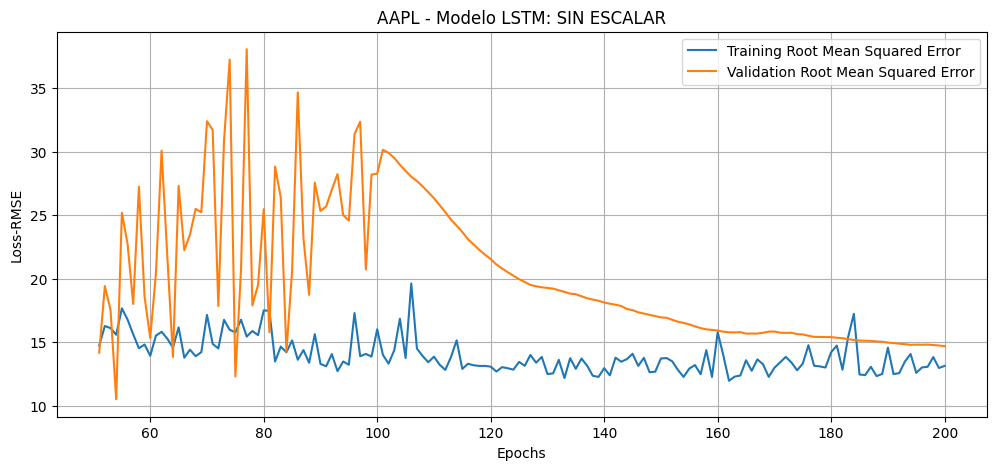

In [236]:
# Graficamos el modelo LSTM:
my_LSTM_model2 = plot_LSTM_forecast('SIN ESCALAR', Train_X, Train_Y, Test_X, Test_Y)

In [279]:
# Calculamos el error RMSE:
predictions_LSTM, rmse_LSTM = LSTM_forecast(my_LSTM_model2, Test_X, Test_Y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Error-Modelo-LSTM: RMSE: 12.041


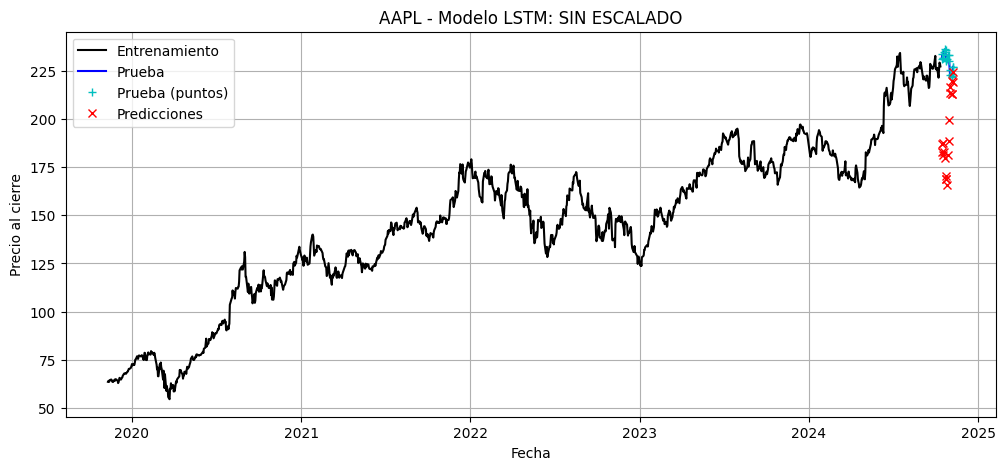

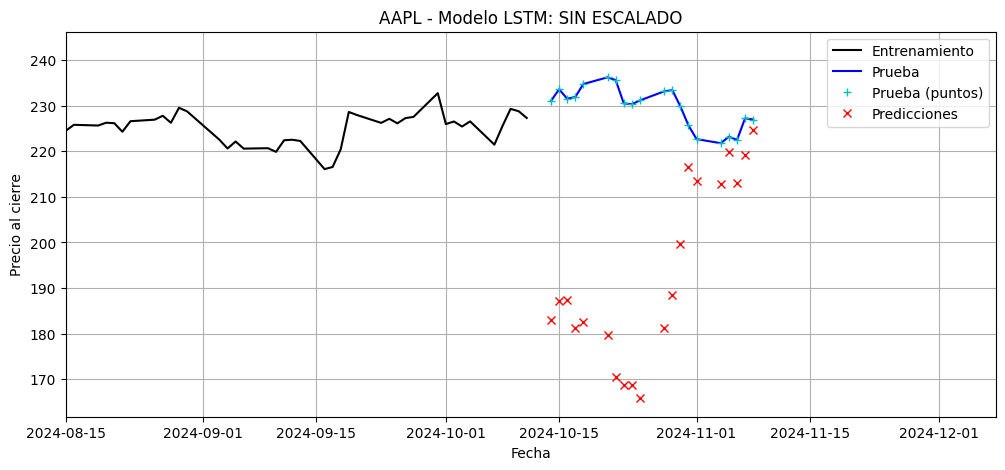

In [317]:
# Graficando las predicciones del modelo LSTM:
plot_LSTM_forecast2('SIN ESCALADO', train_prophet, test_prophet, predictions_LSTM)
plot_LSTM_forecast2('SIN ESCALADO', train_prophet, test_prophet, predictions_LSTM, zoom=True)

## **Modelo LSTM: CON ESCALADO**

In [318]:
# Podemos usar los mismos datos escalados que en el modelo Prophet, pero unidos en un dataframe:
df_scaled = pd.concat([train_prophet_scaled, test_prophet_scaled])

Train_X, Train_Y, Test_X, Test_Y = preparando_datos(pd.DataFrame(df_scaled), threshold_Date)

Epoch 1/200


c:\Users\hille\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.3961 - root_mean_squared_error: 0.6228 - val_loss: 0.6358 - val_root_mean_squared_error: 0.7974 - learning_rate: 0.0500
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1429 - root_mean_squared_error: 0.3774 - val_loss: 0.2970 - val_root_mean_squared_error: 0.5450 - learning_rate: 0.0500
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1094 - root_mean_squared_error: 0.3306 - val_loss: 0.1521 - val_root_mean_squared_error: 0.3900 - learning_rate: 0.0500
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0358 - root_mean_squared_error: 0.1891 - val_loss: 0.1397 - val_root_mean_squared_error: 0.3737 - learning_rate: 0.0500
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0300 - root_mean_squared_error: 0.1733 - val_loss: 0.0801 - val_root_mean_squared_error: 0.2830 - learning_rate: 0.0500
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0288 - root_mean_squared_error: 0.1695 - val_loss: 0

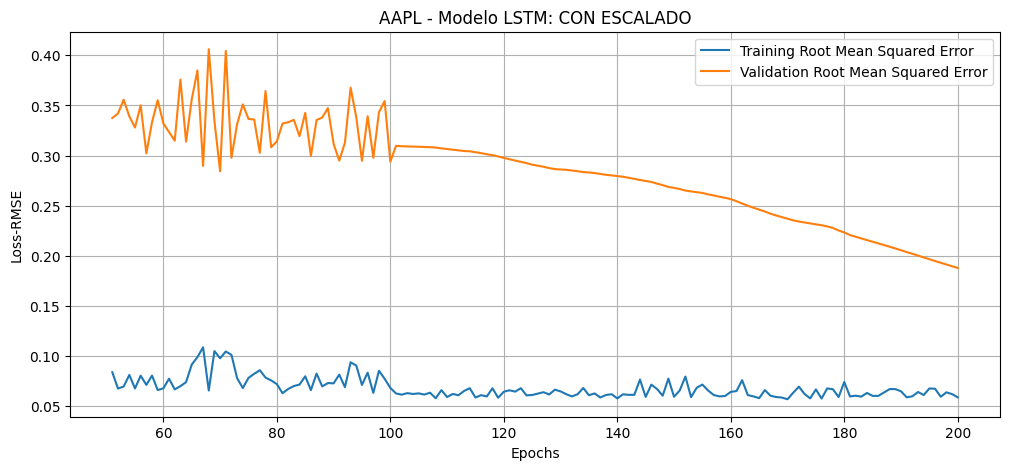

In [319]:
# Graficando el modelo LSTM con datos escalados:
my_LSTM_model2 = plot_LSTM_forecast('CON ESCALADO', Train_X, Train_Y, Test_X, Test_Y)

In [320]:
# Calculando el error RMSE con datos escalados:
predictions_LSTM, rmse_LSTM = LSTM_forecast(my_LSTM_model2, Test_X, Test_Y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

Error-Modelo-LSTM: RMSE: 0.192


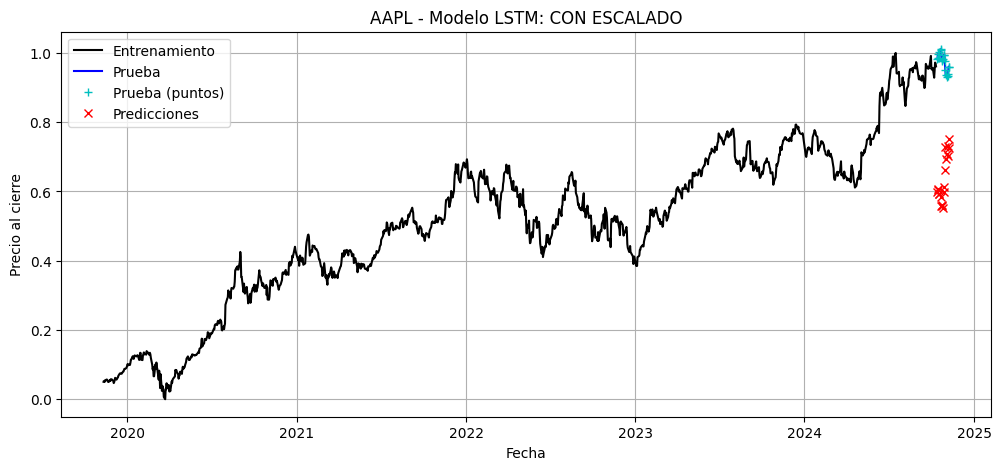

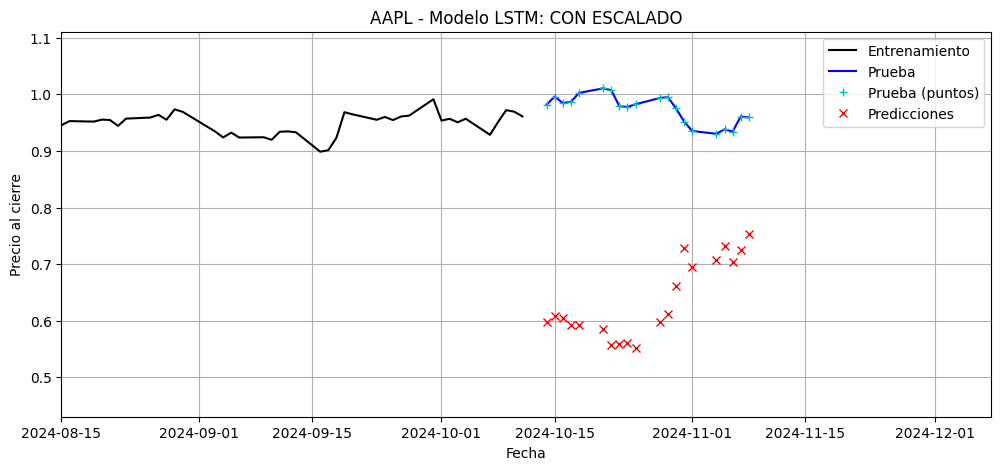

In [332]:
# Graficando las predicciones del modelo LSTM con datos escalados:
plot_LSTM_forecast2('CON ESCALADO', train_prophet_scaled, test_prophet_scaled, predictions_LSTM)
plot_LSTM_forecast2('CON ESCALADO', train_prophet_scaled, test_prophet_scaled, predictions_LSTM, zoom=True)

## **Modelo LSTM: Análisis**

Como podemos observar en la primer gráfica con datos SIN ESCALAR, el modelo LSTM eventualmente logra una buena representación del valor de las acciones de Apple después de unas 100 épocas, aunque la falta de escalado afectó su desempeño en las primeras etapas de entrenamiento.

Ya con el escalado de los datos, se ha mejorado considerablemente el rendimiento y la estabilidad del modelo.

La reducción en la variabilidad del error de validación y su tendencia decreciente indican que el modelo tiene una mejor capacidad de generalización y que podría ser más confiable en la predicción de valores futuros de las acciones de AAPL. Comparado con el modelo sin escalado, este enfoque probablemente ofrecerá predicciones más precisas y consistentes.

El error RSME sin escalado fue de 12.041, mientras que con el escalado de los datos se redujo hasta 0.191, lo que sugiere que escalar los datos es una práctica recomendable para mejorar la estabilidad y precisión de modelos LSTM, especialmente en series temporales financieras.

# **CONSLUSIONES FINALES**


### Tabla de resultados para el Error RMSE

Modelo | Sin Escalado | Con Escalado
--- | --- | ---
Modelo Ingenuo | 2.565 | 0.014
Modelo ARIMA | 2.512 | 0.014
Modelo Prophet | 8.194 | 0.045
Modelo LSTM | 12.041 | 0.192


Como podemos observar, el modelo ARIMA es el modelo que mejor se ajusta a los datos, tanto en la versión escalada como en la no escalada.

El modelo ingenuo, aunque tiene un RMSE similar al de ARIMA, es menos estable y más propenso a errores en la predicción.

Los modelos LSTM y Prophet no se ajustan bien a los datos, ya que tienen un RMSE mucho más alto que ARIMA.

En general, ARIMA es un modelo robusto y estable que puede ser utilizado para predecir series de tiempo financieras.

Sin embargo, es importante tener en cuenta que los resultados pueden variar dependiendo de la serie de tiempo y los parámetros del modelo.

Por lo tanto, es recomendable probar varios modelos y ajustar los parámetros para obtener la mejor predicción posible.

Es importante mencionar que el modelo ARIMA es el que mas tiempo tarda en entrenar, y por mucho, por lo que si se requiere una predicción rápida, se recomienda utilizar otro modelo.

Finalmente, respondiendo a la pregunta **¿Consideras que el escalamiento de los datos ayuda a obtener mejores predicciones?** Sí, el escalamiento de los datos ayuda a obtener mejores predicciones, ya que los modelos de aprendizaje profundo, en particular las redes neuronales, requieren que los datos estén en un rango específico para que puedan converger de manera más rápida y eficiente. Además, el escalamiento de los datos ayuda a mejorar la estabilidad numérica y a evitar problemas de divergencia durante el entrenamiento del modelo. Por lo tanto, al escalar los datos, se puede mejorar la precisión y el rendimiento de los modelos de aprendizaje profundo, lo que puede resultar en predicciones más precisas y confiables.

Gracias por la oportunidad de participar en este curso, ha sido un placer aprender y compartir conocimientos con ustedes!